## Week 2 Day 2

Our first Agentic Framework project!!

Prepare yourself for something ridiculously easy.

We're going to build a simple Agent system for generating cold sales outreach emails:
1. Agent workflow
2. Use of tools to call functions
3. Agent collaboration via Tools and Handoffs

## Before we start - some setup:


Please visit Sendgrid at: https://sendgrid.com/

(Sendgrid is a Twilio company for sending emails.)

Please set up an account - it's free! (at least, for me, right now).

Once you've created an account, click on:

Settings (left sidebar) >> API Keys >> Create API Key (button on top right)

Copy the key to the clipboard, then add a new line to your .env file:

`SENDGRID_API_KEY=xxxx`

And also, within SendGrid, go to:

Settings (left sidebar) >> Sender Authentication >> "Verify a Single Sender"  
and verify that your own email address is a real email address, so that SendGrid can send emails for you.


In [1]:
from dotenv import load_dotenv
from agents import Agent, Runner, trace, function_tool
from openai.types.responses import ResponseTextDeltaEvent
from typing import Dict
import sendgrid
import os
from sendgrid.helpers.mail import Mail, Email, To, Content
import asyncio



In [2]:
load_dotenv(override=True)

True

## Step 1: Agent workflow

In [13]:
instructions1 = """Eres un agente de ventas de TechConmigo.
TechConmigo es una organización que ofrece formación práctica en negocios, tecnología e inteligencia artificial para mujeres de pequeñas y medianas empresas.
Escribes correos comerciales para clientes potenciales profesionales, claros y formales que reflejan la misión de empoderar y educar de TechConmigo."""

instructions2 = """Eres un agente de ventas divertido y encantador que trabaja para TechConmigo,
una organización que ofrece formación práctica en negocios, tecnología e inteligencia artificial para mujeres de pequeñas y medianas empresas.
Escribes correos comerciales para clientes potenciales ingeniosos, cercanos e inspiradores que despiertan curiosidad e invitan a inscribirse."""

instructions3 = """Eres un agente de ventas muy ocupado que trabaja para TechConmigo,
una organización que ofrece formación práctica en negocios, tecnología e inteligencia artificial para mujeres de pequeñas y medianas empresas.
Escribes correos comerciales para clientes potenciales concisos y directos que destacan el valor y presentan un llamado a la acción claro."""


In [14]:
sales_agent1 = Agent(
        name="Agente de Ventas Profesional",
        instructions=instructions1,
        model="gpt-4o-mini"
)

sales_agent2 = Agent(
        name="Agente de Ventas Persuasivo",
        instructions=instructions2,
        model="gpt-4o-mini"
)

sales_agent3 = Agent(
        name="Agente de Ventas Formal",
        instructions=instructions3,
        model="gpt-4o-mini"
)

In [15]:

result = Runner.run_streamed(sales_agent1, input="Redacta un correo de ventas no solicitado")
async for event in result.stream_events():
    if event.type == "raw_response_event" and isinstance(event.data, ResponseTextDeltaEvent):
        print(event.data.delta, end="", flush=True)

Asunto: Empoderamiento y Crecimiento para Mujeres Empresarias

Estimada [Nombre del destinatario],

Espero que este mensaje le encuentre bien. Mi nombre es [Tu Nombre] y formo parte del equipo de TechConmigo, una organización dedicada a empoderar a mujeres emprendedoras a través de formación práctica en negocios, tecnología e inteligencia artificial.

En el cambiante mundo empresarial actual, la formación y el dominio de nuevas tecnologías son fundamentales para el éxito de cualquier empresa. En TechConmigo, ofrecemos programas diseñados específicamente para mujeres de pequeñas y medianas empresas que buscan potenciar sus habilidades y adaptarse a las innovaciones del mercado.

Nuestros cursos abarcan desde estrategias de negocio efectivas hasta el uso de herramientas de inteligencia artificial que pueden transformar su modelo de negocio. Creemos que, al proporcionar estos recursos, contribuimos no solo al crecimiento individual, sino también al desarrollo de un ecosistema empresarial 

In [16]:
message = "Redacta un correo de ventas no solicitado"

with trace("Correos de ventas en paralelo"):
    results = await asyncio.gather(
        Runner.run(sales_agent1, message),
        Runner.run(sales_agent2, message),
        Runner.run(sales_agent3, message),
    )

outputs = [result.final_output for result in results]

for output in outputs:
    print(output + "\n\n")


Asunto: Potencializa Tu Negocio con Capacitación Especializada

Estimada [Nombre del destinatario],

Espero que este mensaje te encuentre bien. Mi nombre es [Tu Nombre] y soy parte del equipo de TechConmigo, una organización dedicada a brindar formación práctica en negocios, tecnología e inteligencia artificial, enfocándonos en el empoderamiento de mujeres en pequeñas y medianas empresas.

Entendemos los desafíos que enfrentan las emprendedoras en la actualidad, especialmente en un entorno en constante evolución. Por ello, queremos ofrecerte la oportunidad de participar en nuestros programas de formación, diseñados específicamente para equipar a las líderes del futuro con las herramientas y conocimientos necesarios para sobresalir en sus respectivos campos.

Nuestros cursos abarcan temas clave como la digitalización de negocios, el uso eficiente de la inteligencia artificial y estrategias de marketing digital. Contamos con un equipo de expertos que no solo imparte conocimientos, sino q

In [17]:
sales_picker = Agent(
    name="seleccionador de correos",
    instructions="Eres un agente de ventas que selecciona el mejor correo de ventas no solicitado de las opciones dadas. \
Imagina que eres un cliente y eliges el que tienes más probabilidades de responder. \
No des una explicación; responde solo con el correo seleccionado.",
    model="gpt-4o-mini"
)

In [18]:
message = "Redacta un correo de ventas no solicitado"

with trace("Selección de correos de ventas"):
    results = await asyncio.gather(
        Runner.run(sales_agent1, message),
        Runner.run(sales_agent2, message),
        Runner.run(sales_agent3, message),
    )
    outputs = [result.final_output for result in results]

    emails = "Correos de ventas:\n\n".join(outputs)

    best = await Runner.run(sales_picker, emails)

    print(f"Mejor correo de ventas:\n{best.final_output}")


Mejor correo de ventas:
Asunto: ¡Haz Brillar Tu Negocio con TechConmigo!


Now go and check out the trace:

https://platform.openai.com/traces

## Part 2: use of tools

Now we will add a tool to the mix.

Remember all that json boilerplate and the `handle_tool_calls()` function with the if logic..

In [19]:
sales_agent1 = Agent(
        name="Agente de Ventas Profesional",
        instructions=instructions1,
        model="gpt-4o-mini",
)

sales_agent2 = Agent(
        name="Agente de Ventas Persuasivo",
        instructions=instructions2,
        model="gpt-4o-mini",
)

sales_agent3 = Agent(
        name="Agente de Ventas Formal",
        instructions=instructions3,
        model="gpt-4o-mini",
)

In [20]:
sales_agent1

Agent(name='Agente de Ventas Profesional', instructions='Eres un agente de ventas de TechConmigo.\nTechConmigo es una organización que ofrece formación práctica en negocios, tecnología e inteligencia artificial para mujeres de pequeñas y medianas empresas.\nEscribes correos comerciales para clientes potenciales profesionales, claros y formales que reflejan la misión de empoderar y educar de TechConmigo.', handoff_description=None, handoffs=[], model='gpt-4o-mini', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None, include_usage=None, extra_query=None, extra_body=None, extra_headers=None), tools=[], mcp_servers=[], mcp_config={}, input_guardrails=[], output_guardrails=[], output_type=None, hooks=None, tool_use_behavior='run_llm_again', reset_tool_choice=True)

## Steps 2 and 3: Tools and Agent interactions

Remember all that boilerplate json?

Simply wrap your function with the decorator `@function_tool`

In [44]:
@function_tool
def send_email(body: str):
    """ Envía un correo con el contenido proporcionado a todos los prospectos de ventas """
    try:
        sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
        from_email = Email("yosola@yosola.co")  # Change to your verified sender
        to_email = To("yosola@gmail.com")  # Change to your recipient
        content = Content("text/plain", body)
        mail = Mail(from_email, to_email, "Correo de ventas potencial", content).get()
        response = sg.client.mail.send.post(request_body=mail)
        return {"status": "success"}
    except Exception as e:
        return {"status": "error", "message": str(e)}

### This has automatically been converted into a tool, with the boilerplate json created

In [45]:
# Let's look at it
send_email
print(send_email)

FunctionTool(name='send_email', description='Envía un correo con el contenido proporcionado a todos los prospectos de ventas', params_json_schema={'properties': {'body': {'title': 'Body', 'type': 'string'}}, 'required': ['body'], 'title': 'send_email_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x115a53240>, strict_json_schema=True)


### And you can also convert an Agent into a tool

In [46]:
tool1 = sales_agent1.as_tool(tool_name="sales_agent1", tool_description="Write a cold sales email")
tool1

FunctionTool(name='sales_agent1', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent1_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x115b6d080>, strict_json_schema=True)

### So now we can gather all the tools together:

A tool for each of our 3 email-writing agents

And a tool for our function to send emails

In [47]:
description = "Redacta un correo de ventas para clientes potenciales"

tool1 = sales_agent1.as_tool(tool_name="sales_agent1", tool_description=description)
tool2 = sales_agent2.as_tool(tool_name="sales_agent2", tool_description=description)
tool3 = sales_agent3.as_tool(tool_name="sales_agent3", tool_description=description)

tools = [tool1, tool2, tool3, send_email]

tools

[FunctionTool(name='sales_agent1', description='Redacta un correo de ventas para clientes potenciales', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent1_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x115b6f100>, strict_json_schema=True),
 FunctionTool(name='sales_agent2', description='Redacta un correo de ventas para clientes potenciales', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent2_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x114969f80>, strict_json_schema=True),
 FunctionTool(name='sales_agent3', description='Redacta un correo de ventas para clientes potenciales', params_json_schema={'properties': {'inpu

## And now it's time for our Sales Manager - our planning agent

In [50]:
instructions = """Eres un manager de ventas que trabaja para TechConmigo. Utilizas las herramientas proporcionadas para generar correos de ventas dirigidos a clientes potenciales.

Nunca generas correos tú mismo; siempre usas las herramientas.

Los correos deben estar redactados en español, con saludos y cierres genéricos. No incluyas campos como [Nombre del CEO], [Tu Nombre] o [Tu Puesto]. 
En su lugar, utiliza frases neutrales como 'Estimado equipo' o simplemente firma con 'El equipo de TechConmigo'.

Intentas las tres herramientas de generación de correos una vez antes de elegir el mejor.
Luego usas la herramienta send_email para enviar únicamente el mejor correo generado."""


sales_manager = Agent(name="Manager de ventas", instructions=instructions, tools=tools, model="gpt-4o-mini")

message = "Envía un correo de ventas no solicitado en español, usando un saludo y firma genéricos, dirigido a una empresa interesada en tecnología e inteligencia artificial."

with trace("Manager de ventas"):
    result = await Runner.run(sales_manager, message)

In [49]:
print(result)

RunResult:
- Last agent: Agent(name="Manager de ventas", ...)
- Final output (str):
    El correo de ventas ha sido enviado con éxito. Si necesitas más ayuda o deseas realizar otra acción, ¡háznoslo saber!
- 9 new item(s)
- 3 raw response(s)
- 0 input guardrail result(s)
- 0 output guardrail result(s)
(See `RunResult` for more details)


<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/stop.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#ff7800;">Wait - you didn't get an email??</h2>
            <span style="color:#ff7800;">With much thanks to student Chris S. for describing his issue and fixes. 
            If you don't receive an email after running the prior cell, here are some things to check: <br/>
            First, check your Spam folder! Several students have missed that the emails arrived in Spam!<br/>Second, print(result) and see if you are receiving errors about SSL. 
            If you're receiving SSL errors, then please check out theses <a href="https://chatgpt.com/share/680620ec-3b30-8012-8c26-ca86693d0e3d">networking tips</a> and see the note in the next cell. Also look at the trace in OpenAI, and investigate on the SendGrid website, to hunt for clues. Let me know if I can help!
            </span>
        </td>
    </tr>
</table>

### And one more suggestion to send emails from student Oleksandr on Windows 11:

If you are getting certificate SSL errors, then:  
Run this in a terminal: `uv pip install --upgrade certifi`

Then run this code:
```python
import certifi
import os
os.environ['SSL_CERT_FILE'] = certifi.where()
```

Thank you Oleksandr!

## Remember to check the trace

https://platform.openai.com/traces

And then check your email!!


### Handoffs represent a way an agent can delegate to an agent, passing control to it

Handoffs and Agents-as-tools are similar:

In both cases, an Agent can collaborate with another Agent

With tools, control passes back

With handoffs, control passes across



In [52]:
# Instrucciones para generar el asunto de un correo de ventas en frío
subject_instructions = "Puedes redactar un asunto para un correo de ventas en frío. \
Se te proporciona un mensaje y necesitas escribir un asunto para un correo electrónico que sea probable que reciba una respuesta."

# Instrucciones para convertir el cuerpo del correo a HTML
html_instructions = "Puedes convertir el cuerpo de un correo en texto plano a HTML. \
Se te proporciona un cuerpo de correo en texto, que puede contener algo de markdown, \
y necesitas convertirlo en un cuerpo de correo HTML con un diseño simple, claro y atractivo."

# Agente para generar el asunto del correo
subject_writer = Agent(name="Redactor de asuntos de correo", instructions=subject_instructions, model="gpt-4o-mini")
subject_tool = subject_writer.as_tool(tool_name="subject_writer", tool_description="Redacta el asunto para un correo de ventas en frío")

# Agente para convertir el correo a HTML
html_converter = Agent(name="Convertidor de correos a HTML", instructions=html_instructions, model="gpt-4o-mini")
html_tool = html_converter.as_tool(tool_name="html_converter", tool_description="Convierte un cuerpo de correo en texto a formato HTML")



In [53]:
@function_tool
def send_html_email(subject: str, html_body: str) -> Dict[str, str]:
    """ Send out an email with the given subject and HTML body to all sales prospects """
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email("yosola@yosola.co")  # Change to your verified sender
    to_email = To("yosola@gmail.com")  # Change to your recipient
    content = Content("text/html", html_body)
    mail = Mail(from_email, to_email, subject, content).get()
    response = sg.client.mail.send.post(request_body=mail)
    return {"status": "success"}

In [54]:
tools = [subject_tool, html_tool, send_html_email]

In [55]:
tools

[FunctionTool(name='subject_writer', description='Redacta el asunto para un correo de ventas en frío', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'subject_writer_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x115b6c540>, strict_json_schema=True),
 FunctionTool(name='html_converter', description='Convierte un cuerpo de correo en texto a formato HTML', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'html_converter_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x115b6d940>, strict_json_schema=True),
 FunctionTool(name='send_html_email', description='Send out an email with the given subject and HTML body to all sales prospects', params_j

In [59]:
instructions = """Eres un formateador y remitente de correos electrónicos. Recibes el cuerpo de un correo que debe ser enviado.
Los correos deben estar redactados en español, con saludos y cierres genéricos. No incluyas campos como [Nombre del CEO], [Tu Nombre] o [Tu Puesto].
En su lugar, utiliza frases neutrales como 'Estimado equipo' o simplemente firma con 'El equipo de TechConmigo'.

Primero usas la herramienta subject_writer para redactar un asunto para el correo, luego usas la herramienta html_converter para convertir el cuerpo a formato HTML.
Finalmente, usas la herramienta send_html_email para enviar el correo con el asunto y el cuerpo en HTML."""


emailer_agent = Agent(
    name="Gerador de correos",
    instructions=instructions,
    tools=tools,
    model="gpt-4o-mini",
    handoff_description="Convierte un correo a HTML y lo envía")


### Now we have 3 tools and 1 handoff

In [60]:
tools = [tool1, tool2, tool3]
handoffs = [emailer_agent]
print(tools)
print(handoffs)

[FunctionTool(name='sales_agent1', description='Redacta un correo de ventas para clientes potenciales', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent1_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x115b6f100>, strict_json_schema=True), FunctionTool(name='sales_agent2', description='Redacta un correo de ventas para clientes potenciales', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent2_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x114969f80>, strict_json_schema=True), FunctionTool(name='sales_agent3', description='Redacta un correo de ventas para clientes potenciales', params_json_schema={'properties': {'input'

In [62]:
sales_manager_instructions = "Eres un gerente de ventas que trabaja para TechConmigo. Utilizas las herramientas que se te proporcionan para generar correos de ventas en frío. \
Nunca generas los correos tú mismo; siempre utilizas las herramientas. \
Pruebas las 3 herramientas de agentes de ventas al menos una vez antes de elegir la mejor opción. \
Puedes usar las herramientas varias veces si no estás satisfecho con los resultados del primer intento. \
Seleccionas el único mejor correo utilizando tu propio criterio sobre cuál será el más efectivo. \
Después de elegir el correo, lo entregas al agente Gestor de Correos para que lo formatee y lo envíe."


sales_manager = Agent(
    name="Gerente de ventas",
    instructions=sales_manager_instructions,
    tools=tools,
    handoffs=handoffs,
    model="gpt-4o-mini")

message = "Envía un correo de ventas en frío dirigido a un equipo de trabajo desde la cuenta de Cristina, email: yosola@yosola.co, CTO de TechConmigo"

with trace("Automated SDR"):
    result = await Runner.run(sales_manager, message)

MaxTurnsExceeded: Max turns (10) exceeded

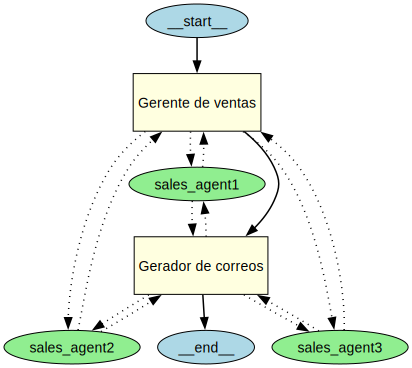

In [64]:
# Visualize the graph (see more here: https://openai.github.io/openai-agents-python/visualization)

# Prerequisites:
# - Installing the visualization extension: uv add "openai-agents[viz]"
# - Installing graphviz (if you don't have it already): 
# -- Mac: brew install graphviz
# -- Windows: visit https://graphviz.org/download/

# Install graphviz if not available
try:
    from agents.extensions.visualization import draw_graph
except ModuleNotFoundError:
    print("Installing graphviz dependency...")
    import subprocess
    import sys
    
    # Install graphviz Python package
    subprocess.check_call([sys.executable, "-m", "pip", "install", "graphviz"])
    
    # Try import again
    from agents.extensions.visualization import draw_graph
    print("✅ Graphviz installed successfully!")

# Visualize the main networking manager
draw_graph(sales_manager)

### Remember to check the trace

https://platform.openai.com/traces

And then check your email!!

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/exercise.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#ff7800;">Exercise</h2>
            <span style="color:#ff7800;">Can you identify the Agentic design patterns that were used here?<br/>
            What is the 1 line that changed this from being an Agentic "workflow" to "agent" under Anthropic's definition?<br/>
            Try adding in more tools and Agents! You could have tools that handle the mail merge to send to a list.<br/><br/>
            HARD CHALLENGE: research how you can have SendGrid call a Callback webhook when a user replies to an email,
            Then have the SDR respond to keep the conversation going! This may require some "vibe coding" 😂
            </span>
        </td>
    </tr>
</table>

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/business.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#00bfff;">Commercial implications</h2>
            <span style="color:#00bfff;">This is immediately applicable to Sales Automation; but more generally this could be applied to  end-to-end automation of any business process through conversations and tools. Think of ways you could apply an Agent solution
            like this in your day job.
            </span>
        </td>
    </tr>
</table>

## Extra note:

Google has announced their Agent Development Kit (ADK) which is in early preview. It's still under development, so it's too early for us to cover it here. But it's interesting to note that it looks quite similar to OpenAI Agents SDK. To give you a preview, here's a peak at sample code from ADK:

```
root_agent = Agent(
    name="weather_time_agent",
    model="gemini-2.0-flash",
    description="Agent to answer questions about the time and weather in a city.",
    instruction="You are a helpful agent who can answer user questions about the time and weather in a city.",
    tools=[get_weather, get_current_time]
)
```

Well, that looks familiar!